# Examples

Here, I want to give a quick walkthrough on how you would probably use `ssvepy`.

In [1]:
import mne
import ssvepy
# get an example data set:
from ssvepy.exampledata import epoch_example


Reading /Users/jan/Dropbox/Documents/side-projects/ssvepy/ssvepy/exampledata/example-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   15996.09 ms
        0 CTF compensation matrices available
16 matching events found
16 matching events found
0 projection items activated


This is a file that's already pre-processed and epoched. You can check it's details like this:

In [2]:
epoch_example

<EpochsFIF  |  n_events : 16 (all good), tmin : 0.0 (s), tmax : 15.99609375 (s), baseline : (0.0, 0.0), ~32.1 MB, data loaded,
 '101': 1, '103': 1, '104': 1, '108': 1, '109': 1, '110': 1, '115': 1, '116': 1, '202': 1, '205': 1, '206': 1, '207': 1, '211': 1, '212': 1, '213': 1, '214': 1>

In this data, the subject was stimulated at 6 Hz.

We can create an SSVEP analysis structure like this:

In [3]:
ssvep_example = ssvepy.Ssvep(epoch_example, [6.0], fmin=0.5, fmax=30,
                             compute_subharmonics=False)

---

## Exploring power and signal-to-noise ratio at evoked frequencies

You can check, for example, what the power at the stimulation frequency was (averaged over all electrodes):

In [4]:
ssvep_example.stimulation.power.mean()

1.6633987290435648e-09

We can also check all the harmonic frequencies in your frequency range. You can investigate the frequencies, which order the frequencies are, and what the frequency power was.

In [5]:
ssvep_example.harmonic.frequencies

array([[ 12.,  18.,  24.]])

In [6]:
ssvep_example.harmonic.orders

array([2, 3, 4])

The numpy array that contains the power values has the following dimensions:

1. Epoch
2. Electrodes
3. Frequencies

We can work out the power at these frequencies by averaging over epochs and electrodes.

There is an array with the same dimensions that holds the signal-to-noise ration for the harmonic frequencies, too.

In [7]:
print(ssvep_example.harmonic.power.shape)
ssvep_example.harmonic.power.mean(axis=(0, 1))

(16, 64, 3)


array([  7.32671447e-10,   2.48359140e-10,   1.20176901e-10])

In [8]:
print(ssvep_example.harmonic.snr.shape)
ssvep_example.harmonic.snr.mean(axis=(0, 1))

(16, 64, 3)


array([ 1.68739754,  1.23014751,  1.07890902])

As you can see, the signal amplitude and signal-to-noise ratio decreases with each harmonic, with the fourth harmonic (24 Hz) already having almost no signal.

The calculation for this SNR is by default done by dividing the average power at a given frequency and dividing it by the average power in a 1 Hz band around it. You can set the width of this _noise_ band yourself when you create the `Ssvep` class.

---

## Plotting

We can easily visualise both the power spectrum and the SNR spectrum:

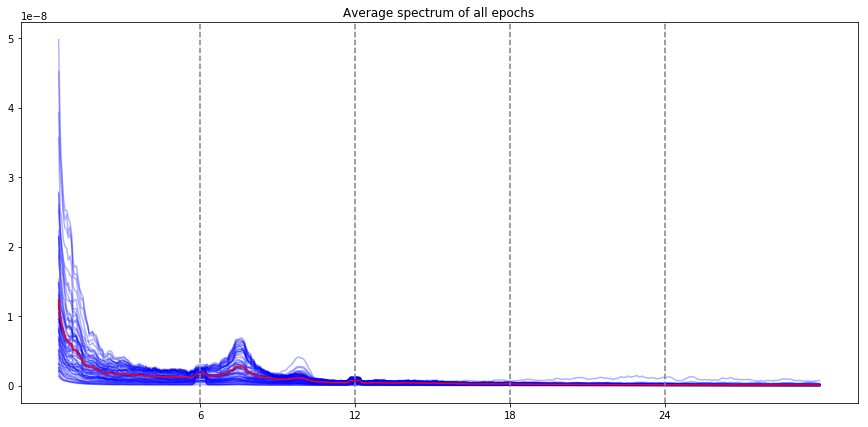

In [9]:
ssvep_example.plot_psd()

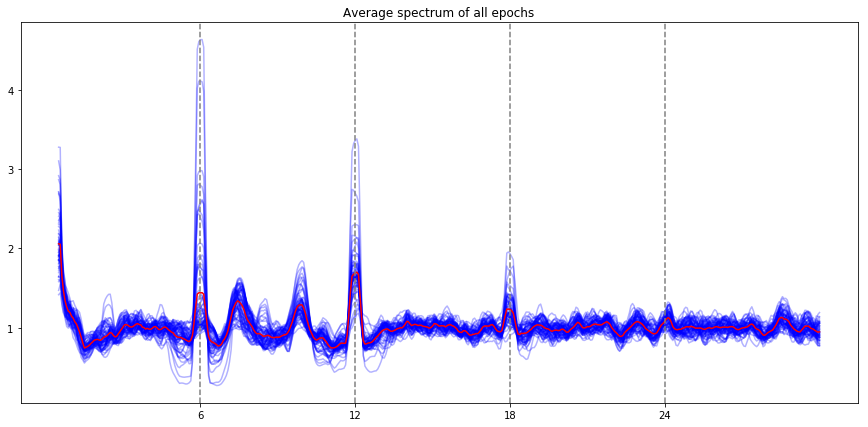

In [10]:
ssvep_example.plot_snr()

Note: the red line is the average of all electrodes, the blue lines are individual electrode. By default, all the __evoked__ frequencies that have been evaluated (fundamental, harmonic, subharmonic) are indicated by vertical lines (the stimulation frequency, and the harmonics / subharmonics.

We can also visualise this on a scalp plot. This usually requires you to have set the montage of the raw / epoched data before you create the ssvep analysis data structure:

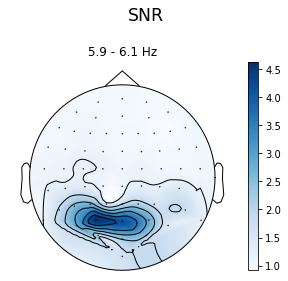

In [11]:
ssvep_example.topoplot_snr()

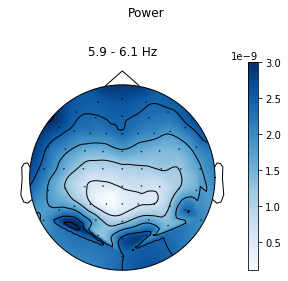

In [12]:
ssvep_example.topoplot_psd()

Just to compare, we can also plot the signal-to-noise-ratio for a random frequency using the `flims` parameter. To compare it to the SNR plot above we can set the `vmax` to something in line with the previous plot:

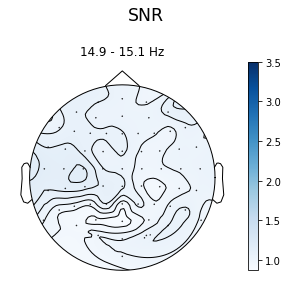

In [13]:
ssvep_example.topoplot_snr(flims=15, vmax=3.5)

And again, you can plot these for the non-linear products of the stimulation frequency:

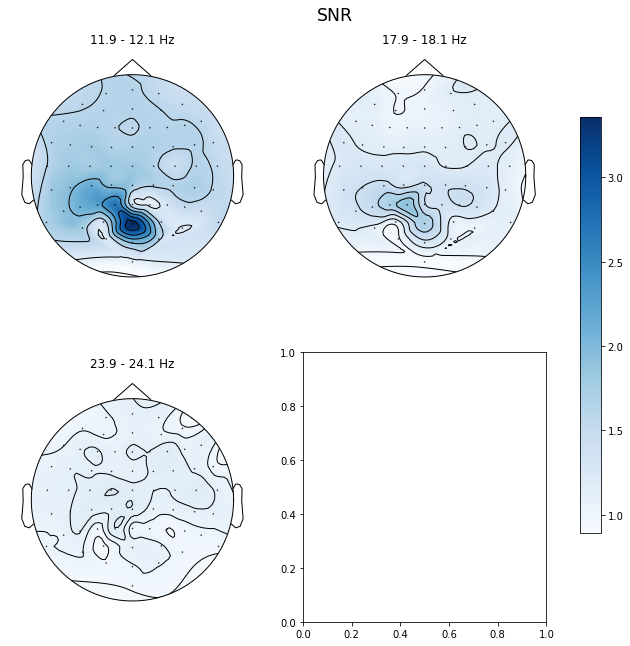

In [14]:
ssvep_example.topoplot_snr(flims='harmonic', figsize=(12, 10))

---

## Exploring time-frequency decompositions of your data

You can also explore the time-frequency relationship of your entrained frequencies. This uses the recursive-least-squares method (described in Tang & Norcia, 1995). By default turned off, you can enable it by passing the argument `compute_tfr=True` during class creation. It takes a while, but will evaluate the time-frequency relationship of all the evoked frequencies you specified.

The resulting data has the dimensions of MNE-standard frequency data:

1. Trial / Epoch
2. Electrode
3. Frequency
4. Time

In [16]:
ssvep_example = ssvepy.Ssvep(epoch_example, 6.0, fmin=2, fmax=30, compute_tfr=True, compute_subharmonics=False)

print(ssvep_example.stimulation.tfr.shape)

(16, 64, 1, 4096)


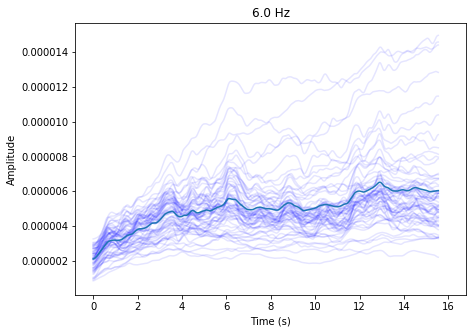

In [17]:
ssvep_example.plot_tfr()

---

## Using your evoked frequency data to classify epochs

You can also use your evoked frequeny data for classification. Ssvepy can do two types of classification: It can classify an epoch, based on a model trained on other epoch data, and it can classify timepoints, based on other timepoints. I will first show you how to classify epochs.

In the example data, on half the trials (trigger code 1XX), faces were rhythmically presented at 1.2 Hz. During the other half, faces were presented at completely random intervals, meaning there was no 1.2 Hz rhythm. Here, we'll see if we can use SSVEPs to classify these trials.

(_NB: this is not best practice. There were only 16 trials here, which is not usually enough for machine learning classification to make any sense. But this is just a demonstration._)

For this, we need a list of labels. This list needs to have the exact same size as the number of epochs in our ssvep structure. Since the trial labels were effectively encoded in the trigger codes, I can use this to construct a list of labels:

In [18]:
labels = (epoch_example.events[:, -1] // 100) - 1

labels

array([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0], dtype=int32)

We can use these labels to train a model, and it will return a predicted label for each trial, as well as a score. It will use the average signal-to-noise ratio for each epoch, for each electrode, for each evoked frequency (including stimulation, and all intermodulation/subharmonic frequencies).

By default, it uses `sklearn.linear_model.LogisticRegressionCV`, a linear logistic regression model that will use cross-validation to optimise the parameters and avoid overfitting.

In [ ]:
predictions = ssvep_example.predict_epochs(labels)

print(labels)
print(predictions)
print((labels==predictions).mean())

We can also provide a different algorithm for classifying the epochs - they have to follow the scikit learn standard of being classes with a `fit(X, y)`, `predict(X)` and `score(X, y)` method, but otherwise could be anything. Let's try a different scikit learn algorithm:

In [ ]:
import sklearn.svm

predictions = ssvep_example.predict_epochs(labels, method=sklearn.svm.SVC())

print(labels)
print(predictions)
print((labels==predictions).mean())